<a href="https://colab.research.google.com/github/AtSourav/AE-w.-Bottleneck-Residual-Blocks/blob/main/AE_cifar10_residual_blocks_m3_CBloss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll train m3 using the continuous bernoulli log loss (1907.06845) for the sake of comparison.



In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import metrics
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

from google.colab import files

In [1]:
! git clone https://github.com/AtSourav/AE-w.-Bottleneck-Residual-Blocks

%cd "/content/AE-w.-Bottleneck-Residual-Blocks"

import Residual_blocks as resblock

Cloning into 'AE-w.-Bottleneck-Residual-Blocks'...
remote: Enumerating objects: 264, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 264 (delta 42), reused 21 (delta 4), pack-reused 168
Receiving objects: 100% (264/264), 9.17 MiB | 25.65 MiB/s, done.
Resolving deltas: 100% (123/123), done.
/content/AE-w.-Bottleneck-Residual-Blocks


In [3]:
img_ht = 32
img_wd = 32
input_size = (img_ht,img_wd,3)

batch_size = 128

### **Loading the dataset**

In [4]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteACWNHN/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteACWNHN/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


# **Latent dim 320**

In [5]:
K.clear_session()

latent_dim = 320

initializer = initializers.HeNormal(seed=123)
#initializer = initializers.GlorotUniform()

### **The model**

In [6]:
encoder_input = keras.Input(shape=input_size)

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(encoder_input)

#####################################################################################

# the default padding is 'valid'

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(256, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.Flatten()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 bridge_residual_conv2d_blo  (None, 28, 28, 64)        39488     
 ck (bridge_residual_conv2D                                      
 _block)                                                         
                                                                 
 bridge_residual_conv2d_blo  (None, 24, 24, 128)       230784    
 ck_1 (bridge_residual_conv                                      
 2D_block)                                                       
                                                                 
 residual_conv2d_block (res  (None, 24, 24, 128)       296192    
 idual_conv2D_block)                                             
                                                           

In [7]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = resblock.bridge_residual_conv2Dtrans_block(1024, 1, 1, initializer)(x)

##############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer, padding='same')(x)

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer)(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer)(x)

#############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(64, 1, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(64, 1, 2, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

###########################################################################################

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320)]             0         
                                                                 
 dense_1 (Dense)             (None, 640)               205440    
                                                                 
 re_lu_25 (ReLU)             (None, 640)               0         
                                                                 
 dense_2 (Dense)             (None, 1280)              820480    
                                                                 
 re_lu_26 (ReLU)             (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 4096)              5246976   
                                                                 
 re_lu_27 (ReLU)             (None, 4096)              0   

In [8]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()


Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 320)               17197056  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         23272835  
                                                                 
Total params: 40469891 (154.38 MB)
Trainable params: 40445699 (154.29 MB)
Non-trainable params: 24192 (94.50 KB)
_________________________________________________________________


### **Continuous Bernoulli loss**

In [9]:
l_cutoff = 0.495       # these are hyperparameters
u_cutoff = 0.505       # for the range of values within these limits, we shall use the taylor expansion

def norm_CB(z):                                  # the norm of the Continuous Bernoulli loss function

    gate = math.logical_and(math.greater(z,l_cutoff), math.greater(u_cutoff,z))

    z = tf.clip_by_value(z, clip_value_min = K.epsilon(), clip_value_max = 1 - K.epsilon())     # to avoid running into inf and nan values
    z_reg = tf.where(gate, l_cutoff, z)          # this is so the norm_reg below does not evaluate at z when z is close to the problematic value of z=0.5, otherwise we get NaNs. We use the taylor expansion to compute the loss at z=0.5 anyway.


    norm_reg = (2*math.atanh(1 - 2*z_reg))/(1 - 2*z_reg)         # this is the part meant to be used beyond the cutoff limits specified above
    norm_taylor = 2.0 + (8.0/3.0)*math.pow(z-0.5,2) + (32.0/5.0)*math.pow(z-0.5,4)  +  (128.0/7.0)*math.pow(z-0.5,6)          # the taylor expansion that we use within the cutoff limits


    norm = tf.where(gate, norm_taylor, norm_reg)          # when an element of gate is true, the corresponding element of norm_taylor is returned, otherwise the corresponding element of norm_reg is returned

    return norm

@tf.function
def CB_logloss(true, pred):
  true = layers.Flatten()(true)
  pred = layers.Flatten()(pred)
  bce = losses.binary_crossentropy(true,pred)

  corrected_loss_tensor = bce - tf.reduce_mean(math.log(norm_CB(pred)), axis=-1 )    # the binary cross entropy loss corrected with the normalisation factor
                                                                                    # the bce is built to average across the axes other than the batch axis, we do this for the norm manually

  return tf.reduce_mean(corrected_loss_tensor)            #  averaging across the batch axis


### **Training**

In [10]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=10, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss=CB_logloss, metrics=['accuracy'])
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=80, callbacks=[callback])

Epoch 1/80
391/391 [==============================] - 110s 162ms/step - loss: -0.1804 - accuracy: 0.4843 - val_loss: -0.2217 - val_accuracy: 0.4816
Epoch 2/80
391/391 [==============================] - 56s 143ms/step - loss: -0.2882 - accuracy: 0.5486 - val_loss: -0.2742 - val_accuracy: 0.5760
Epoch 3/80
391/391 [==============================] - 56s 143ms/step - loss: -0.3297 - accuracy: 0.6013 - val_loss: -0.3127 - val_accuracy: 0.6123
Epoch 4/80
391/391 [==============================] - 56s 143ms/step - loss: -0.3509 - accuracy: 0.6179 - val_loss: -0.3057 - val_accuracy: 0.6205
Epoch 5/80
391/391 [==============================] - 58s 147ms/step - loss: -0.3637 - accuracy: 0.6251 - val_loss: -0.3254 - val_accuracy: 0.6191
Epoch 6/80
391/391 [==============================] - 57s 147ms/step - loss: -0.3733 - accuracy: 0.6304 - val_loss: -0.3470 - val_accuracy: 0.6339
Epoch 7/80
391/391 [==============================] - 58s 147ms/step - loss: -0.3786 - accuracy: 0.6339 - val_loss: -

In [11]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=1, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.00005)
AE.compile(optimizer=optim,loss=CB_logloss, metrics=['accuracy'])
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=80, callbacks=[callback])

Epoch 1/80
391/391 [==============================] - 89s 148ms/step - loss: -0.4596 - accuracy: 0.7479 - val_loss: -0.4198 - val_accuracy: 0.7308
Epoch 2/80
391/391 [==============================] - 56s 143ms/step - loss: -0.4603 - accuracy: 0.7482 - val_loss: -0.4116 - val_accuracy: 0.7312
Epoch 3/80
391/391 [==============================] - 58s 147ms/step - loss: -0.4605 - accuracy: 0.7483 - val_loss: -0.4209 - val_accuracy: 0.7348
Epoch 4/80
391/391 [==============================] - 56s 143ms/step - loss: -0.4612 - accuracy: 0.7482 - val_loss: -0.4164 - val_accuracy: 0.7289
Epoch 5/80
391/391 [==============================] - 56s 142ms/step - loss: -0.4611 - accuracy: 0.7490 - val_loss: -0.4184 - val_accuracy: 0.7371
Epoch 6/80
391/391 [==============================] - 56s 143ms/step - loss: -0.4616 - accuracy: 0.7491 - val_loss: -0.4195 - val_accuracy: 0.7348
Epoch 7/80
391/391 [==============================] - 56s 143ms/step - loss: -0.4620 - accuracy: 0.7494 - val_loss: -0

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.00001, decay_steps=1564, decay_rate=0.75)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, start_from_epoch=16, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = lr_schedule)
AE.compile(optimizer=optim,loss=CB_logloss, metrics=['accuracy'])
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=60, callbacks=[callback])

Epoch 1/60
391/391 [==============================] - 91s 152ms/step - loss: -0.4748 - accuracy: 0.7602 - val_loss: -0.4168 - val_accuracy: 0.7354
Epoch 2/60
391/391 [==============================] - 56s 142ms/step - loss: -0.4752 - accuracy: 0.7609 - val_loss: -0.4183 - val_accuracy: 0.7367
Epoch 3/60
391/391 [==============================] - 56s 143ms/step - loss: -0.4755 - accuracy: 0.7613 - val_loss: -0.4190 - val_accuracy: 0.7373
Epoch 4/60
391/391 [==============================] - 56s 143ms/step - loss: -0.4757 - accuracy: 0.7612 - val_loss: -0.4175 - val_accuracy: 0.7376
Epoch 5/60
391/391 [==============================] - 58s 148ms/step - loss: -0.4758 - accuracy: 0.7612 - val_loss: -0.4168 - val_accuracy: 0.7372
Epoch 6/60
391/391 [==============================] - 56s 143ms/step - loss: -0.4760 - accuracy: 0.7611 - val_loss: -0.4175 - val_accuracy: 0.7378
Epoch 7/60
391/391 [==============================] - 56s 143ms/step - loss: -0.4760 - accuracy: 0.7614 - val_loss: -0

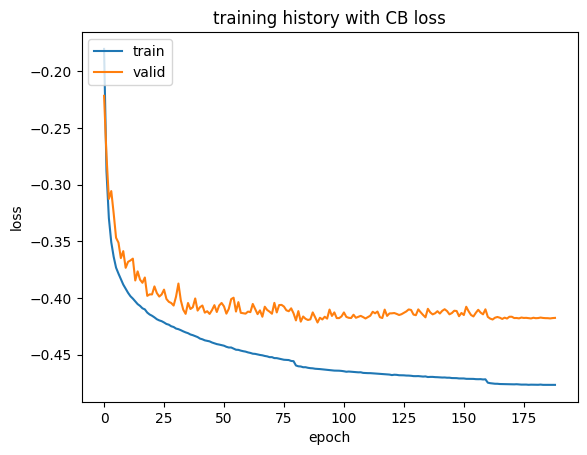

In [14]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss'])

plt.title('training history with CB loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','valid'], loc='upper left')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/Training_m3_CBloss.png')
plt.show()

The training and validation set accuracy values obtained, at 75.29 and 73.65 respectively, are slightly worse as compared to when training with mse loss.

In [15]:
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/Training_m3_CBloss.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Reconstructions based on the above**

In [16]:
def plot_reconstruction(set, name,seed_val, epochs, scale, model_name):

  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(np.ceil(9*scale),np.ceil(4*scale)))
  recon.suptitle(model_name + ' with latent_dim = ' + str(latent_dim) +': reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs', fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

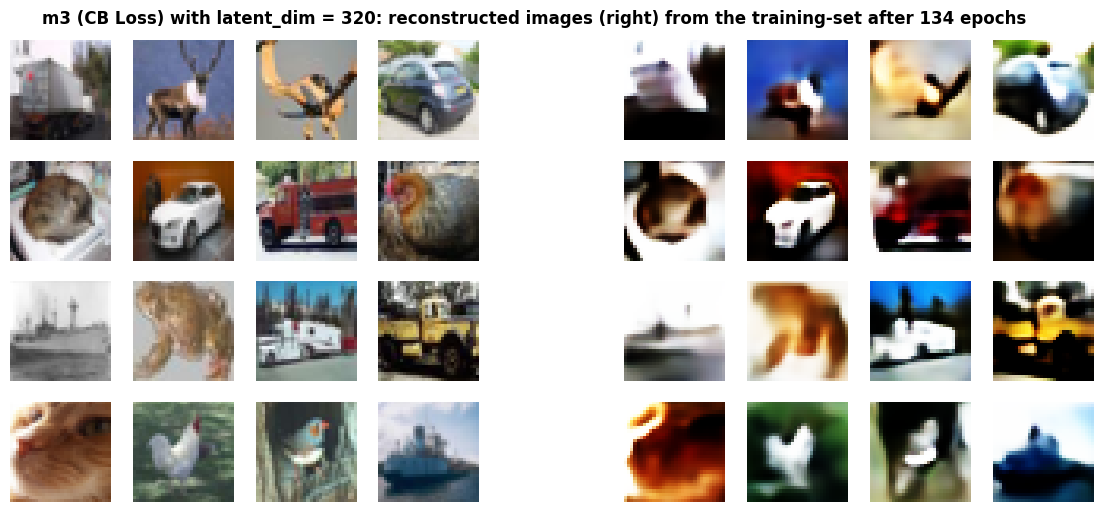

In [17]:
plot_reconstruction(img_train, 'training', 123, 134, 1.5, 'm3 (CB Loss)')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_TrainSet_1.png')

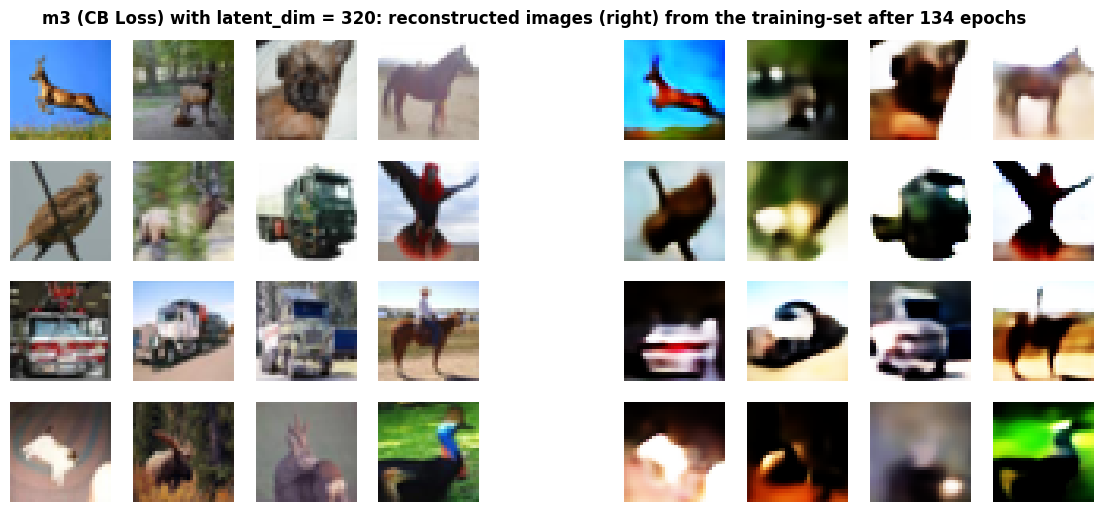

In [18]:
plot_reconstruction(img_train, 'training', 1000, 134, 1.5, 'm3 (CB Loss)')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_TrainSet_2.png')

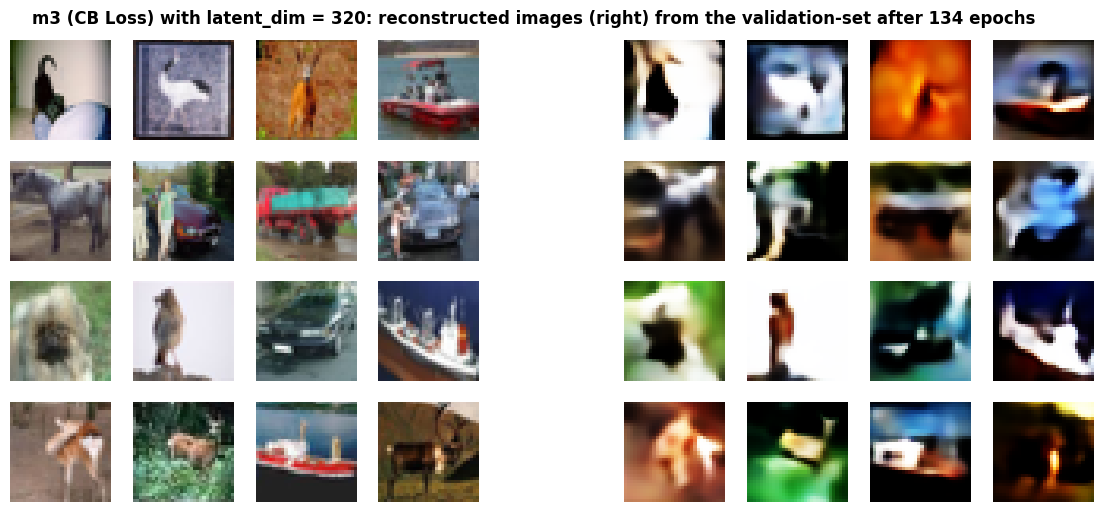

In [19]:
plot_reconstruction(img_valid, 'validation', 123, 134, 1.5, 'm3 (CB Loss)')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_ValidSet_1.png')

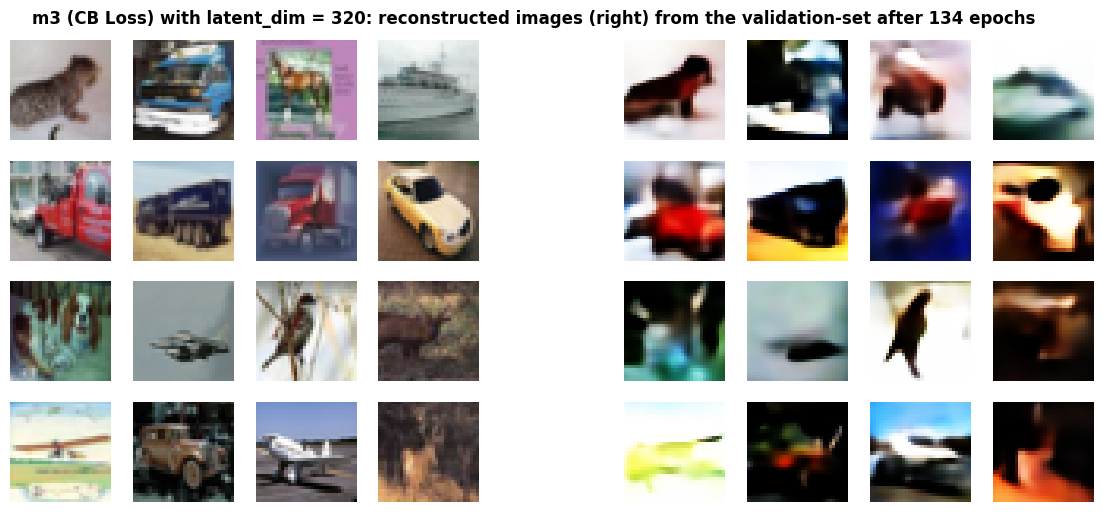

In [20]:
plot_reconstruction(img_valid, 'validation', 1000, 134, 1.5, 'm3 (CB Loss)')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_ValidSet_2.png')

In [21]:
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_TrainSet_1.png')
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_TrainSet_2.png')
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_ValidSet_1.png')
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_CBloss_reconstructions_ValidSet_2.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Conclusions**

The reconstructions have sharp colours (and this high contrast) as expected, but this also means we lose detail.